In [1]:
import numpy as np
import torch

from transformers.optimization import AdamW
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader

import random
import os
import model
from utils import dataset, file, train

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [3]:
MAX_SEQ_LEN = 100
LABEL_LIST = ["O", "B-ASP", "I-ASP", "[CLS]", "[SEP]"]
label_map = {i: label for i, label in enumerate(LABEL_LIST, 1)}
THRESHOLD_SRD = 5
NUM_POL_CLASSES = 3
LCF = 'cdw'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 2e-5
BATCH_SIZE = 8
N_EPOCHS = 60
DROPOUT_ATE = 0.1
DROPOUT_ASC = 0.1
DROPOUT_OUT = 0.1
WEIGHT_DECAY = 1e-6
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [4]:
train_data_14 = file.read_train_test_files_new('../data/rests/Restaurants_2014.train.txt')
test_data_14 = file.read_train_test_files_new('../data/rests/Restaurants_2014.test.txt')

train_data_15 = file.read_train_test_files_new('../data/rests/Restaurants_2015.train.txt')
test_data_15 = file.read_train_test_files_new('../data/rests/Restaurants_2015.test.txt')

train_data_16 = file.read_train_test_files_new('../data/rests/Restaurants_2016.train.txt')
test_data_16 = file.read_train_test_files_new('../data/rests/Restaurants_2016.test.txt')

all_test_data = test_data_14 + test_data_15 + test_data_16
all_train_data = train_data_14 + train_data_15 + train_data_16

unique_test_data = []
unique_train_data = []

for x in all_train_data:
    if x not in unique_train_data:
        unique_train_data.append(x)

for x in all_test_data:
    if x not in unique_test_data and x not in unique_train_data:
        unique_test_data.append(x)

In [5]:
train_dataset = dataset.ATEPCDataset('train_test',
                                     'simple',
                                     [sample[0] for sample in unique_train_data],
                                     [sample[1] for sample in unique_train_data],
                                     [sample[2] for sample in unique_train_data],
                                     tokenizer,
                                     MAX_SEQ_LEN,
                                     THRESHOLD_SRD,
                                     'ru_core_news_sm')

test_dataset = dataset.ATEPCDataset('train_test',
                                    'simple',
                                    [sample[0] for sample in unique_test_data],
                                    [sample[1] for sample in unique_test_data],
                                    [sample[2] for sample in unique_test_data],
                                    tokenizer,
                                    MAX_SEQ_LEN,
                                    THRESHOLD_SRD,
                                    'ru_core_news_sm')

In [6]:
len(train_dataset)

4811

In [7]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [4330, 481])

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
ATEPCNet = model.LCF_ATEPC(MODEL_NAME, 
                           False, 
                           True, 
                           DROPOUT_ATE, 
                           DROPOUT_ASC, 
                           DROPOUT_OUT,
                           MAX_SEQ_LEN, 
                           LCF, 
                           device, 
                           NUM_POL_CLASSES)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.pred

In [10]:
ATEPCNet.to(device)
optimizer = AdamW(ATEPCNet.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS)

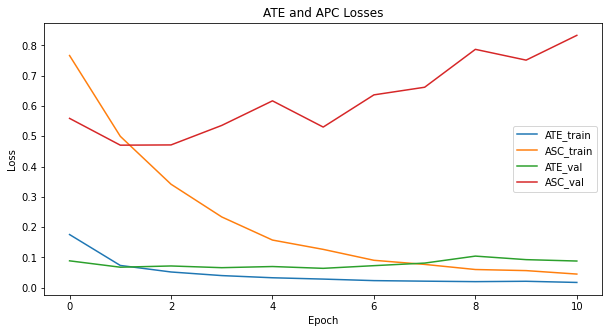

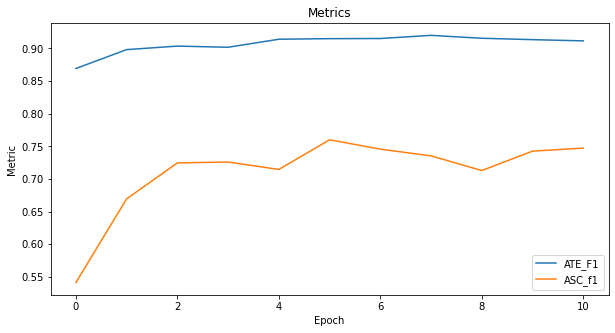

 18%|█▊        | 11/60 [32:32<2:24:55, 177.46s/it]


KeyboardInterrupt: 

In [11]:
train.train_eval(ATEPCNet,
                 train_dataloader,
                 val_dataloader,
                 optimizer,
                 N_EPOCHS,
                 '../trained_models/showcase.pt',
                 scheduler,
                 device,
                 eval_ATE=True,
                 eval_ASC=True)

In [12]:
ATEPCNet.load_state_dict(torch.load('../trained_models/showcase.pt', map_location=device))
ATEPCNet.to(device)
_, _, f1_ATE, f1_ASC = train.eval_loop(ATEPCNet, test_dataloader, eval_ATE=True, eval_ASC=True)
print(f1_ATE, f1_ASC)

0.8373293194280185 0.7304018847610031
